https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-download-tutorial-10-key-features-005-visualization-py

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
import optuna
from reprpo.hp.helpers import optuna_df
from reprpo.training import train
from reprpo.experiments import experiment_configs
from reprpo.hp.space import search_spaces
from optuna.study.study import storages, get_all_study_names
from reprpo.hp.helpers import get_params, get_optuna_df


[2024-10-10 04:16:53,022] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.dpi'] = 80
rcParams['figure.figsize'] = 4,2

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from reprpo.hp.target import override, default_tuner_kwargs
from reprpo.experiments import experiment_configs
import copy

## Objective

In [6]:
SEED=42
key_metric = "acc_gain_vs_ref/oos"

In [7]:
f_db = f"sqlite:///optuna.db"
f = f_db.replace('sqlite:///', './')
print(f)
Path(f).parent.mkdir(parents=True, exist_ok=True)
f_db

./optuna.db


'sqlite:///optuna.db'

## Opt

Note on pruning. It's only really usefull with validation metrics and for long jobs over many epochs. I've got a small proxy job so there is no need.

In [8]:
def plot_param_importances(study, key_metric):
    df_res = get_optuna_df(study, key_metric)
    df2 = study.trials_dataframe().query('state == "COMPLETE"').sort_values('value', ascending=False)

    # plot_param_importances(study)
    # plt.show()

    for i in range(len(df_res)):
        row = df_res.iloc[i]
        param = row.name
        best = row.best
        x = f"params_{param}"
        hue = df2[x].apply(lambda x: x == best)
        if row.dist=='categorical':
            p = sns.catplot(data=df2, x=x, y="value", kind="boxen", 
                        #height=3, 
                        height=2, aspect=3,
                        legend=False,
                        hue=hue)
        else:
            plt.figure(figsize=(6, 2))
            sns.scatterplot(data=df2, x=x, y='value', hue=hue, alpha=0.5, ax=plt.gca())
            sns.scatterplot(data=df2[hue], x=x, y='value', ax=plt.gca(), marker='x', color='red', s=100)
            # TODO if it's a log dist make log
        plt.legend('off').remove()
        if isinstance(best, float):
            best = f"{best:.3g}"
        plt.title(f"{param} i={row.importance:2.2g} best={best}")
        plt.xlabel(None)
        # plt.ylabel(key_metric)
        plt.show()

In [10]:

study_names = get_all_study_names(storage=f_db)
res = {}
for study_name in study_names:
    study = optuna.load_study(study_name=study_name, storage=f_db)
    try:
        v = study.best_trial.values[0]
        df_res2 = optuna_df(study, key_metric)

        df = study.trials_dataframe().sort_values('value', ascending=False)
        n_c = len(df.query('state == "COMPLETE"'))
        n = len(df)
        dd = df['value'].dropna()
        nn = len(dd)//10
        top10 = dd.head(nn).mean()
        res[study_name] = dict(
            n_trials=n, best=v, n_trials_completed=n_c,
            top10_mean=top10,
            )
        # round just the numeric rows
        # print(df_res2.to_markdown())
        df_res2 = df_res2.applymap(lambda x: float(f"{x:2.3g}") if isinstance(x, (float,)) else x)
        print(df_res2.to_markdown())
        print()
    except ValueError as e:
        pass

df_res = pd.DataFrame(res).T.sort_values('best', ascending=False)
print(df_res.to_markdown())

| side-ether-prefvec N=✓208/209, best=1.169   |   importance | best     |
|:--------------------------------------------|-------------:|:---------|
| β                                           |        0.217 | 0.404    |
| Htype                                       |        0.177 | oft      |
| use_angle_loss                              |        0.145 | True     |
| use_dpo_loss                                |        0.144 | False    |
| weight_tokens                               |        0.1   | False    |
| lr                                          |        0.09  | 0.000615 |
| use_nll_loss                                |        0.041 | False    |
| nb                                          |        0.027 | 30       |
| collect_hs                                  |        0.015 | False    |
| use_orth_loss                               |        0.015 | False    |
| collect_input                               |        0.01  | False    |
| reduction                           

## plots

In [10]:
from optuna.visualization.matplotlib import plot_optimization_history
# plot_optimization_history(study)

projgrad2


[W 2024-10-09 11:31:08,310] There are no complete trials.


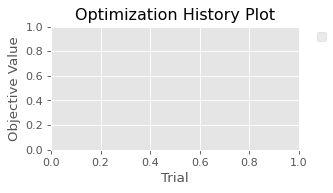

[W 2024-10-09 11:31:08,516] Study instance does not contain completed trials.


,importance,best
"projgrad2 N=✓0/315, best=nan",,


[W 2024-10-09 11:31:09,073] Study instance does not contain completed trials.


-
side-ether-prefvec


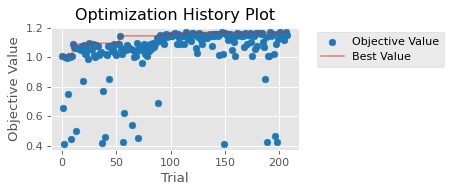

,importance,best
"side-ether-prefvec N=✓208/209, best=1.169",,
β,0.216,0.403787
use_angle_loss,0.155,True
Htype,0.154,oft
use_dpo_loss,0.146,False
lr,0.111,0.000615
weight_tokens,0.076,False
nb,0.029,30
collect_hs,0.026,False
use_nll_loss,0.025,False


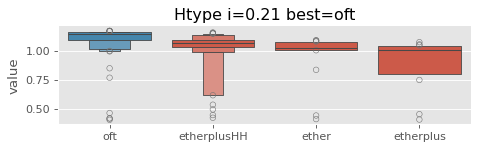

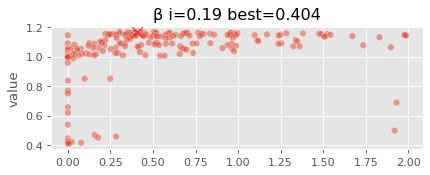

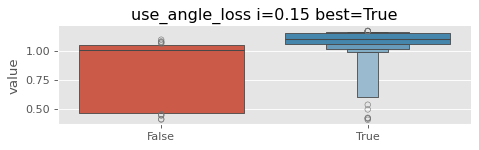

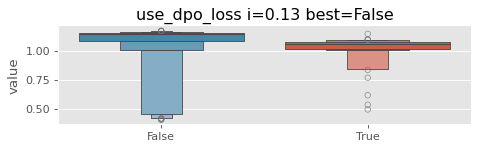

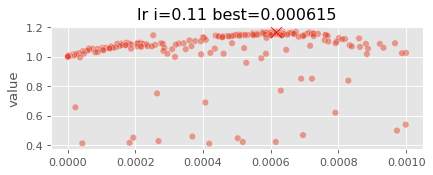

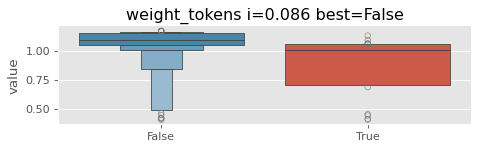

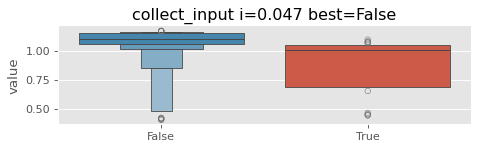

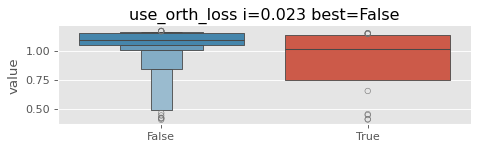

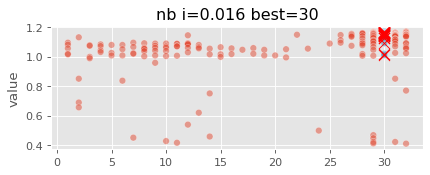

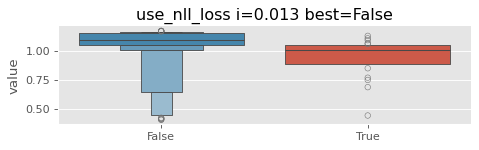

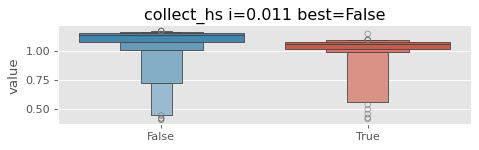

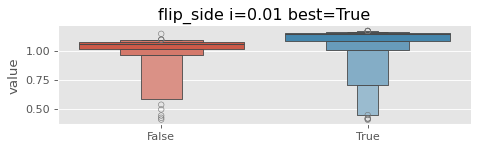

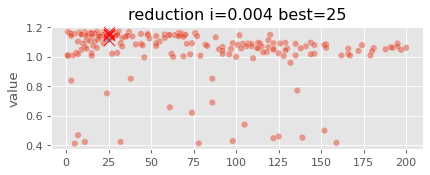

projgrad


[W 2024-10-09 11:31:15,207] There are no complete trials.


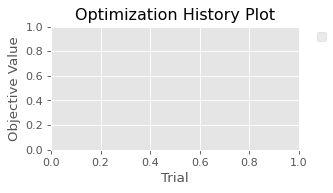

[W 2024-10-09 11:31:15,324] Study instance does not contain completed trials.


,importance,best
"projgrad N=✓0/4, best=nan",,


[W 2024-10-09 11:31:15,388] Study instance does not contain completed trials.


-
side-svd-mse


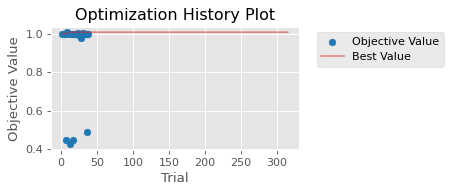

,importance,best
"side-svd-mse N=✓28/316, best=1.010",,
lr,0.962,0.001195
α,0.033,0.635584
collect_input,0.004,False
quantile,0.001,float
collect_hs,0.000,True
dual_svd,0.000,True
quantile_value,NaN,0.3


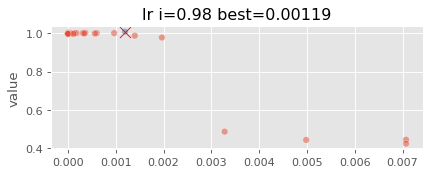

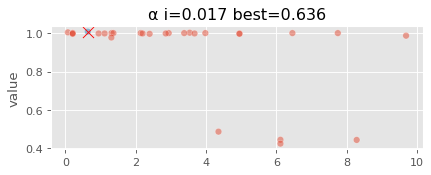

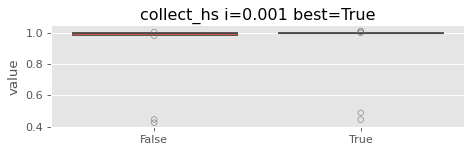

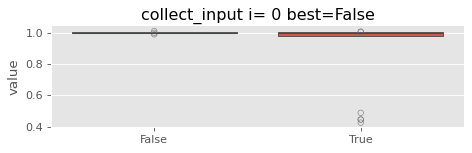

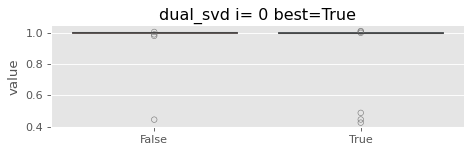

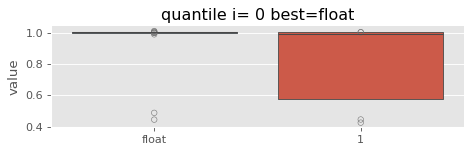

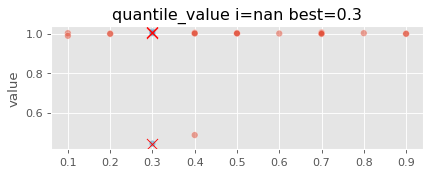

side-hra-rank


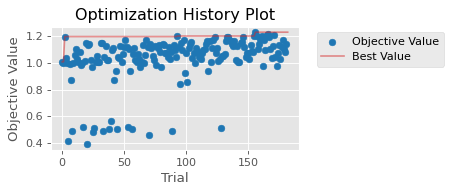

,importance,best
"side-hra-rank N=✓182/183, best=1.229",,
lr,0.917,0.000188
collect_input,0.048,False
collect_hs,0.017,False
apply_GS,0.011,False
r,0.002,2
α,0.002,5.920778
β,0.002,0.110393


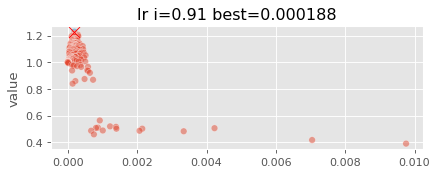

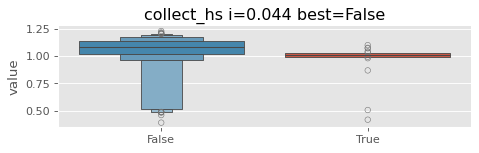

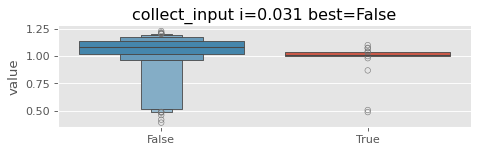

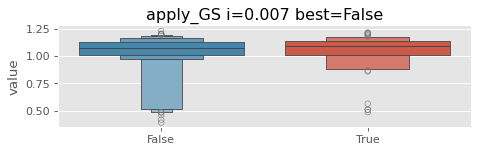

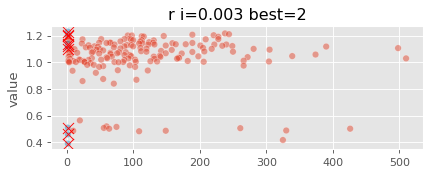

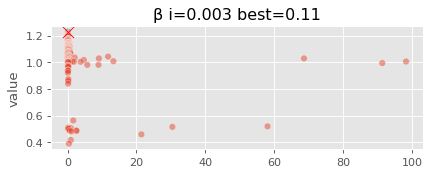

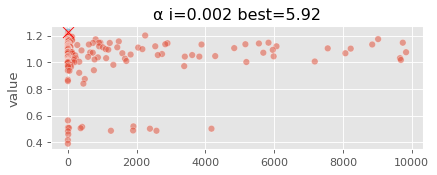

hs-ortho-prefvec


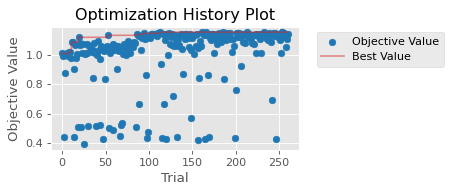

,importance,best
"hs-ortho-prefvec N=✓259/261, best=1.152",,
lr,0.916,0.000411
β,0.040,1.970152
use_angle_loss,0.017,True
orthogonal_map,0.011,matrix_exp
use_dpo_loss,0.006,False
weight_tokens,0.003,False
use_nll_loss,0.003,True
use_proj_rel,0.002,True
use_orth_loss,0.002,True


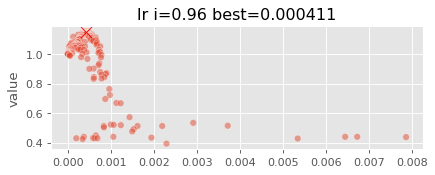

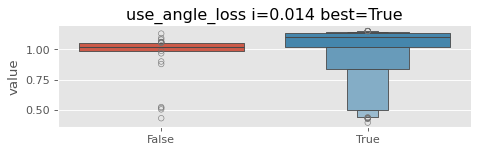

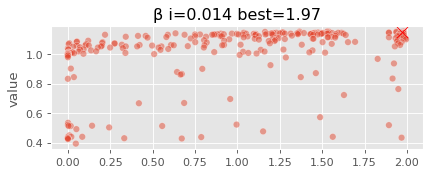

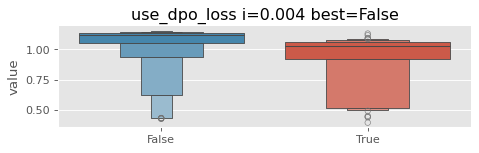

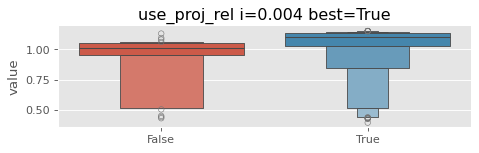

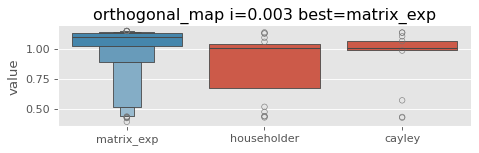

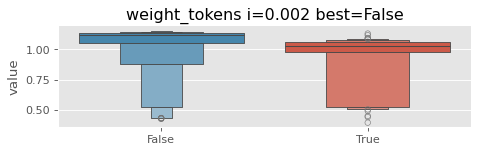

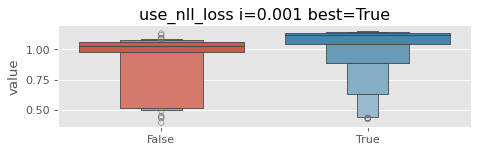

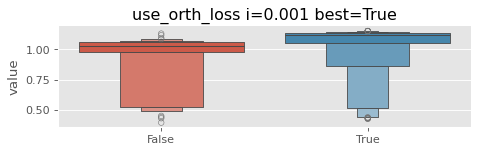

projbp


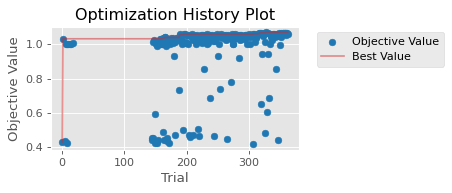

,importance,best
"projbp N=✓227/363, best=1.071",,
scale_orth,0.419,False
β,0.327,0.238377
lr,0.247,0.000005
neg_slope,0.003,float
reverse_pref,0.003,True
mag_clip,0.001,float
mag_clip_value,NaN,0.981465
neg_slope_value,NaN,0.69867


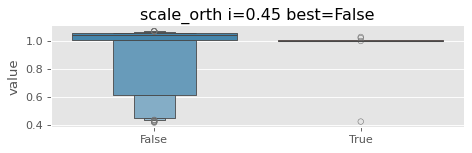

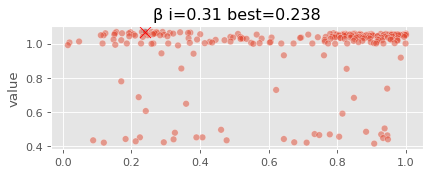

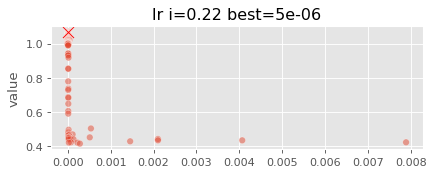

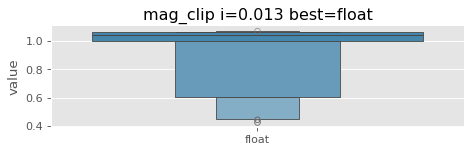

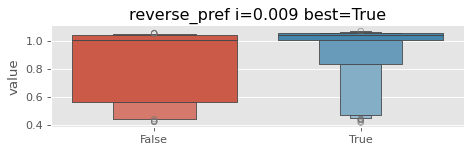

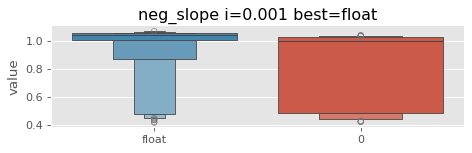

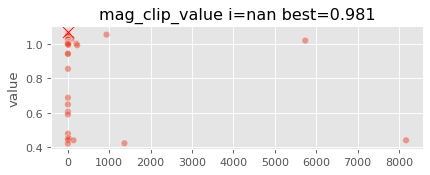

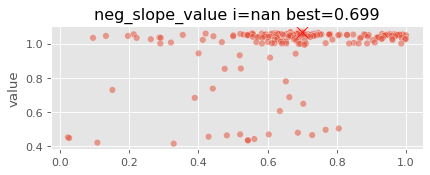

dpo


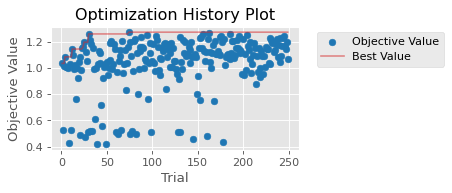

,importance,best
"dpo N=✓248/250, best=1.276",,
lr,1.0,0.000265


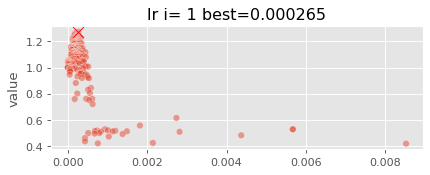

hs-svd-mse


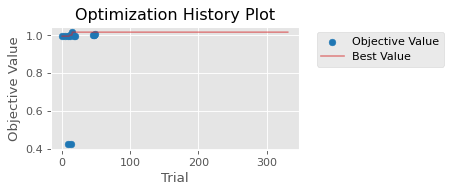

,importance,best
"hs-svd-mse N=✓14/332, best=1.017",,
lr,0.927,0.001195
α,0.047,0.635584
collect_input,0.014,False
quantile,0.012,float
dual_svd,0.000,True
collect_hs,0.000,True
quantile_value,NaN,0.3


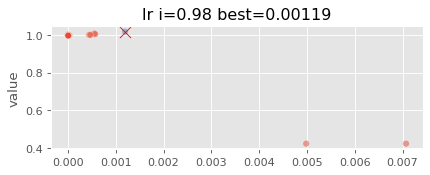

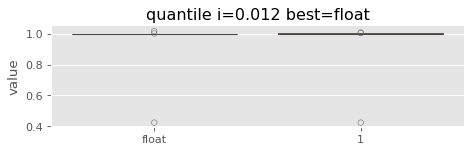

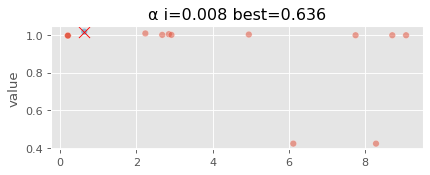

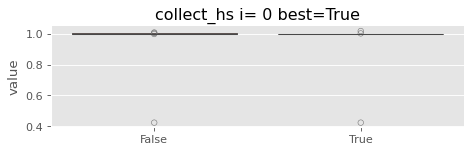

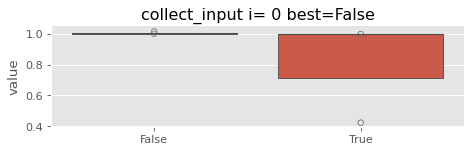

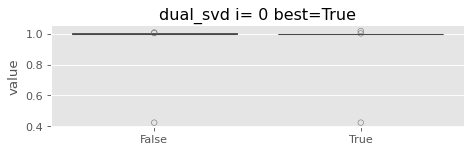

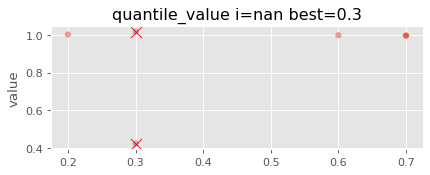

hs-hra-rank


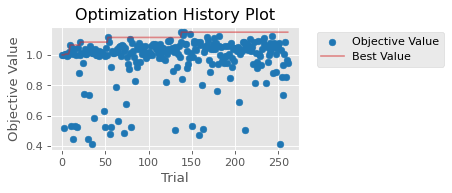

,importance,best
"hs-hra-rank N=✓259/262, best=1.152",,
lr,0.875,0.000333
r,0.098,38
β,0.025,0.37992
apply_GS,0.002,True
α,0.000,0.280164


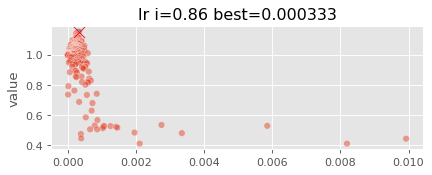

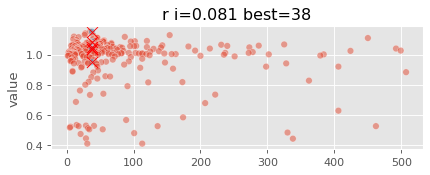

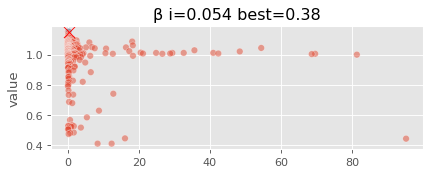

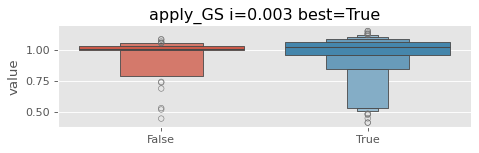

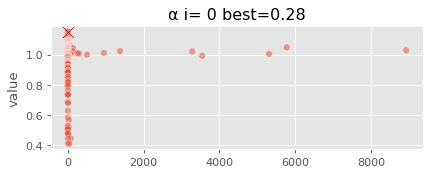

ether-prefvec


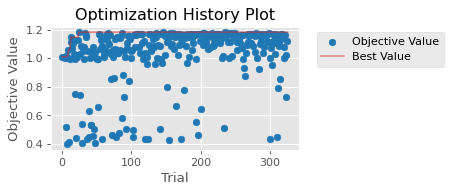

,importance,best
"ether-prefvec N=✓321/327, best=1.183",,
lr,0.792,0.000378
β,0.120,1.984854
reduction,0.030,1
use_angle_loss,0.014,True
nb,0.008,20
use_proj_rel,0.007,True
Htype,0.007,ether
flip_side,0.005,True
use_orth_loss,0.004,True


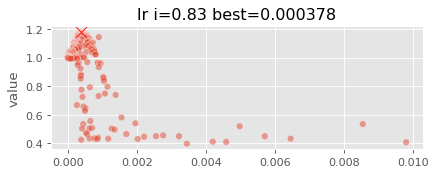

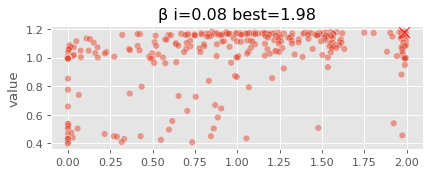

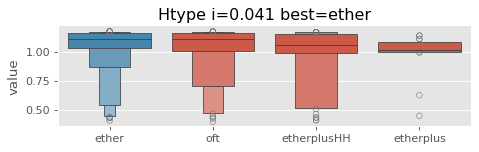

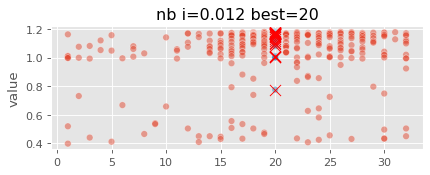

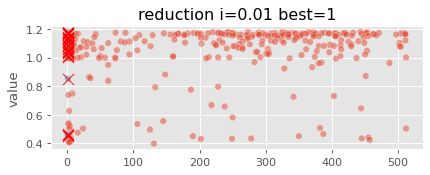

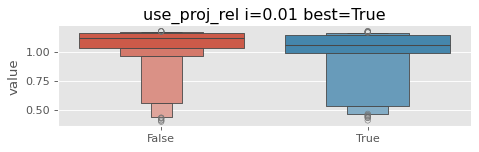

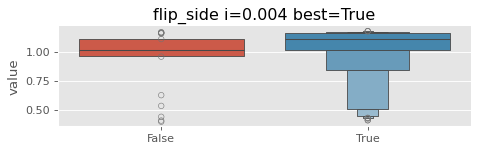

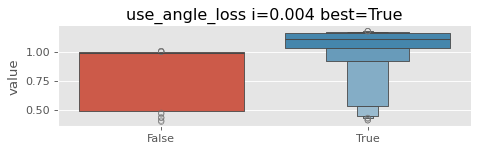

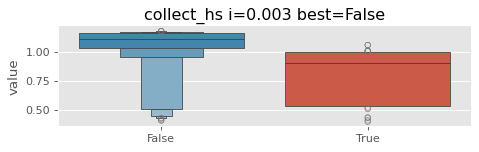

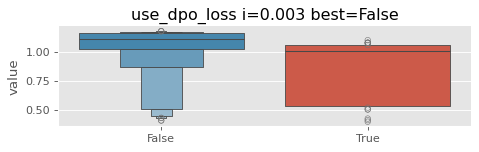

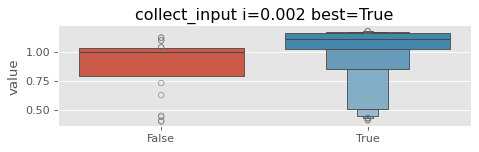

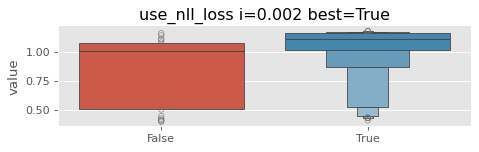

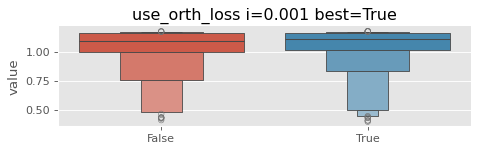

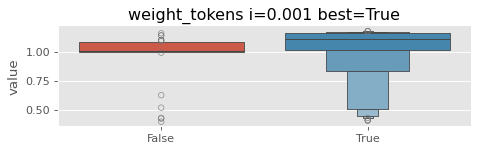

projgrad3


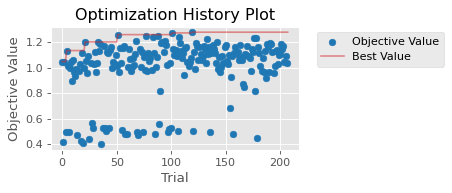

,importance,best
"projgrad3 N=✓207/208, best=1.279",,
lr,0.891,0.000232
β,0.068,0.842679
weight_dim,0.027,1
scale_orth,0.006,False
mag_clip,0.004,float
neg_slope,0.003,0
reverse_pref,0.002,True
mag_clip_value,NaN,0.230096


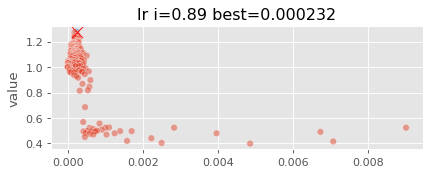

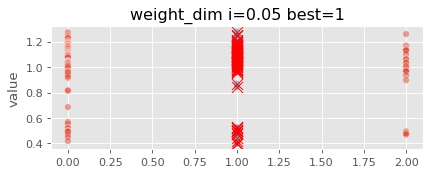

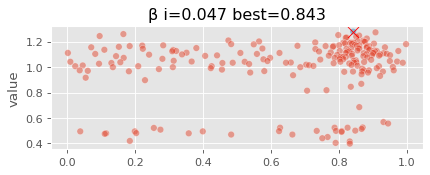

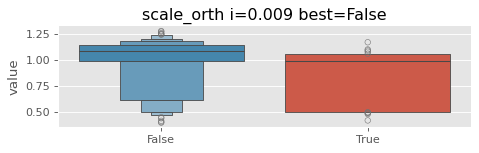

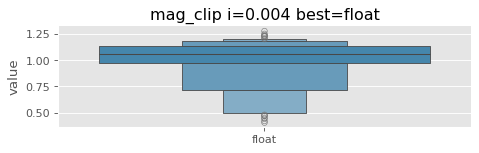

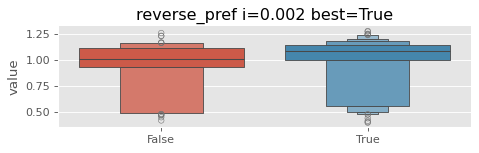

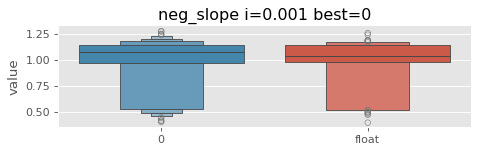

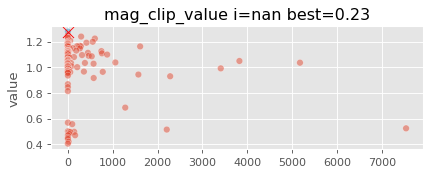

In [11]:

study_names = get_all_study_names(storage=f_db)

for study_name in study_names:
    print(study_name)
    study = optuna.load_study(study_name=study_name, storage=f_db)
    try:
        plot_optimization_history(study)
        plt.show()
        df_res2 = optuna_df(study, key_metric)
        display(df_res2)
        plot_param_importances(study, key_metric)
        # print()
    except ValueError as e:
        print('-')
    print('='*80)